In [1]:
import os
import sys
import warnings
import laspy
sys.path.append("/data1/yang_liu/python_workspace/GSPL")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random
import rawpy
import cv2
import torch
import json
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from defisheye import Defisheye
from plyfile import PlyData, PlyElement
from internal.utils.gaussian_projection import build_rotation_matrix

## 1. Read Data

In [2]:
def read_ply(pcd_path):
    
    plydata = PlyData.read(pcd_path)
    data = plydata.elements[0].data
    property_names = data[0].dtype.names
    data = pd.DataFrame(data)

    data_np = np.zeros(data.shape, dtype=float)
    for i, name in enumerate(property_names):
        data_np[:, i] = data[name]
    
    return data_np

In [3]:
aerial_path = '../data/GKD/aerial'
ground_path = '../data/GKD/ground'

aerial_pcd = read_ply(os.path.join(aerial_path, "point_cloud.ply"))
ground_pcd = read_ply(os.path.join(ground_path, "point_cloud.ply"))
aerial_xyz = aerial_pcd[:, :3]
ground_xyz = ground_pcd[:, :3]
aerial_rgb = aerial_pcd[:, 3:6] if aerial_pcd[:, 3:6].max() <= 1 else aerial_pcd[:, 3:6] / 255.0
ground_rgb = ground_pcd[:, 3:6] if ground_pcd[:, 3:6].max() <= 1 else ground_pcd[:, 3:6] / 255.0

print(f"aerial point cloud shape: {aerial_pcd.shape}")
print(f"ground point cloud shape: {ground_pcd.shape}")

aerial point cloud shape: (7101922, 6)
ground point cloud shape: (5904813, 6)


## 2. Points Projection

In [43]:
def projection(pcd_xyz, pcd_rgb, w2c, K, H, W):
    pcd_xyz_h = np.dot(np.concatenate([pcd_xyz, np.ones((pcd_xyz.shape[0], 1))], axis=-1), w2c.T)
    mask = pcd_xyz_h[:, 2] > 0
    pcd_xyz_h = pcd_xyz_h[mask, :3]
    pcd_rgb_h = pcd_rgb[mask]

    pcd_xyz_cam = pcd_xyz_h / pcd_xyz_h[:, [2]]
    pcd_xyz_cam = np.dot(pcd_xyz_cam, K.T)

    # Filter out points outside the image
    valid_pos = np.where(np.all(pcd_xyz_cam >= 0, axis=-1) & (pcd_xyz_cam[:, 0] < W) & (pcd_xyz_cam[:, 1] < H))
    xyz_proj = pcd_xyz_cam[valid_pos]
    rgb_proj = pcd_rgb_h[valid_pos]
    sort_idx = np.argsort(-pcd_xyz_h[valid_pos][:, 2])
    xyz_proj = xyz_proj[sort_idx]
    rgb_proj = rgb_proj[sort_idx]

    return xyz_proj, rgb_proj

(472240.0, 472460.0, 4474824.0, 4474956.0)

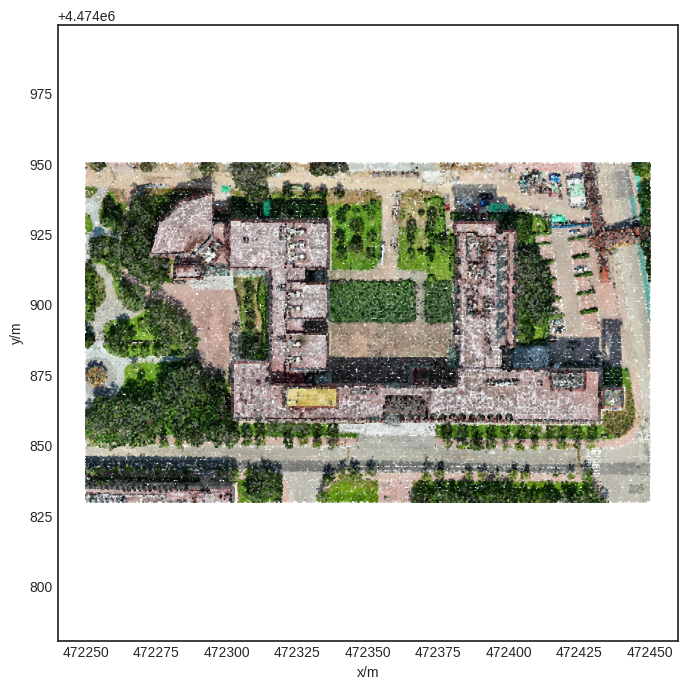

In [30]:
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(aerial_pcd[::10, 0], aerial_pcd[::10, 1], c=aerial_rgb[::10], s=0.1)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')

In [78]:
data_path = ground_path  # aerial_path or ground_path
transforms = json.load(open(os.path.join(data_path, "transforms.json")))
intrinsics = np.array([
    [transforms["fl_x"], 0, transforms["cx"]],
    [0, transforms["fl_y"], transforms["cy"]],
    [0, 0, 1]
])
H, W = transforms["h"], transforms["w"]
print(f"intrinsics:\n {intrinsics}")

aerial intrinsics:
 [[1.824e+03 0.000e+00 1.823e+03]
 [0.000e+00 1.824e+03 1.823e+03]
 [0.000e+00 0.000e+00 1.000e+00]]


In [101]:
frame_idx = random.randint(0, len(transforms["frames"]) - 1)
# frame_idx = 2429
frame = transforms["frames"][frame_idx]
frame_img = cv2.imread(os.path.join(data_path, "images", f"{frame['frame_index']:05d}.png"))
frame_img = cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB)
assert frame_img.shape[:2] == (H, W)
c2w = np.array(frame["rot_mat"], dtype=float)
w2c = np.linalg.inv(c2w)
print(f"c2w:\n {c2w}")
print(f"w2c:\n {w2c}")

c2w:
 [[ 9.40593417e-01 -1.13046182e-01 -3.20163462e-01  4.72351630e+05]
 [ 3.39532466e-01  3.09442468e-01  8.88235884e-01  4.47485022e+06]
 [-1.33952498e-03 -9.44174707e-01  3.29442382e-01  8.36867872e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
w2c:
 [[ 9.40593350e-01  3.39532458e-01 -1.33950330e-03 -1.96364758e+06]
 [-1.13046202e-01  3.09442479e-01 -9.44174746e-01 -1.33123217e+06]
 [-3.20163471e-01  8.88235971e-01  3.29442408e-01 -3.82352076e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [102]:
xyz_proj, rgb_proj = projection(ground_xyz, ground_rgb, w2c, intrinsics, H, W)  # aerial_xyz or ground_xyz, aerial_rgb or ground_rgb

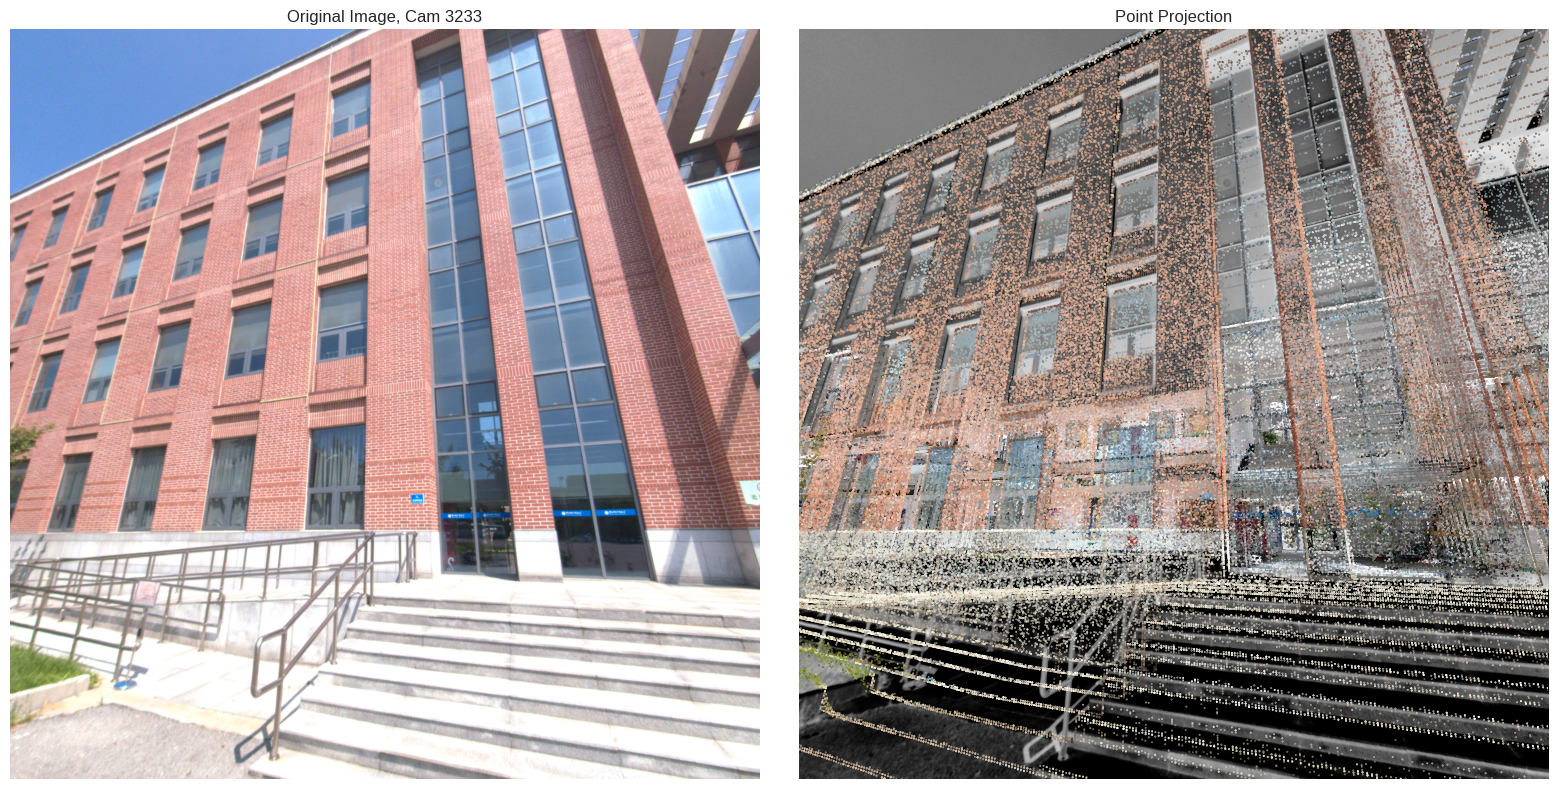

In [103]:
vis_interval = 1
plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(frame_img)
plt.title("Original Image, Cam %d" % frame['frame_index'])
plt.axis("off")
plt.tight_layout()

plt.subplot(122)
plt.title("Point Projection")
plt.imshow(cv2.cvtColor(frame_img, cv2.COLOR_RGB2GRAY))
plt.scatter(xyz_proj[::vis_interval, 0], xyz_proj[::vis_interval, 1], c=rgb_proj[::vis_interval], s=0.1)
plt.xlim(0, W)
plt.ylim(H, 0)

plt.axis("off")
plt.tight_layout()